<a href="https://colab.research.google.com/github/wolfm/Obstacle-Detection-442/blob/master/Detectron2_with_MODD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

Always run the following code block when connecting to a new machine

It installs the Colab-specific dependencies for detectron2

This section comes directly from the Detectron2 Getting Started Colab Notebook

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Train on MODD2 Dataset

We use [the MODD2 dataset](https://github.com/bborja/modd)
which only has one class: obstacle.

We'll train an obstacle detection model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

## Prepare the dataset

In [0]:
# Get MODD2 data - this code block is only necessary if you dont use the git
# clone in the next code block (git clone is recommended method otherwise you
# have to change filepaths in get_data())
!wget http://box.vicos.si/borja/modd2_dataset/MODD2_video_data_rectified.zip
!wget http://box.vicos.si/borja/modd2_dataset/MODD2_annotations_v2_rectified.zip
!unzip MODD2_video_data_rectified.zip > /dev/null
!unzip MODD2_annotations_v2_rectified.zip > /dev/null

In [0]:
# Run this as it is the recommended method of downloading the dataset
import os
from getpass import getpass
user = getpass('GITHUB user')
password = getpass('GITHUB password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/wolfm/Obstacle-Detection-442.git
%cd Obstacle-Detection-442/
!git submodule init
!git submodule update
%cd ..

Register the MODD2 dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [0]:
# Always run this file after grabbing the data from git. It inits the data
# loading functions.

# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import numpy as np
import json
from detectron2.structures import BoxMode
from scipy.io import loadmat


def get_data(d):
    dataset_list = []

    # TODO: change annotation in the next line to the local directory of your annotation data set
    for root,dir,files in os.walk('Obstacle-Detection-442/data/annotationsV2_rectified_'+d):
        if len(root)>64:
            
            annot_dir_path = root
            dir_name_parsed = annot_dir_path.split('/', 5)[3]
            
            for file_name in files:
                # record is a dict contains info of 1 training image
                record = {}
                file_name_parsed = file_name.split('.')[0][:-1]

                # data file path
                # TODO: change image_data to the local directory of your image dataset
                full_image_path = 'Obstacle-Detection-442/data/video_data' + '/'+ str(dir_name_parsed) + '/'+'framesRectified'+ '/'+file_name_parsed + 'L.jpg'
                record["file_name"] = full_image_path

                # data file name
                image_file_name = file_name_parsed + 'L.jpg'
                record["image_id"] = image_file_name

                # data image height (all of modd2 has image size of 1278x958)
                record["height"] = 958

                # data image width (all of modd2 has image size of 1278x958)
                record["width"] = 1278

                # process annotation
                full_path = annot_dir_path + '/' + str(file_name)
                annot = loadmat(full_path)['annotations']
                sea_edge = annot['sea_edge'][0, 0].tolist()
                obstacle = annot['obstacles'][0, 0]

                # annotation_list contains dict of instance in a training image
                annotation_list = []
                if obstacle.shape[0] > 0:
                    for i in range(obstacle.shape[0]):
                        bbox = obstacle[i,:].tolist()
                        bbox_mode = BoxMode.XYWH_ABS

                        # annotation_instance is a dict that contains info of one instance in one training image
                        #   
                        # removed <"segmentation":sea_edge,> because coco interprets as a mask for true segmentation
                        # rather than a line labelling the water's edge
                        annotation_instance = {
                            "bbox":bbox, 
                            "bbox_mode":bbox_mode, 
                            "category_id":0,
                            "iscrowd":0
                        }
                        annotation_list.append(annotation_instance)

                record["annotations"] = annotation_list

                # adding entry to the dataset dictionary
                dataset_list.append(record)
    dataset_list = dataset_list + get_aug_data(d) + get_translation_data(d)

    return dataset_list

In [0]:
# Run this file after grabbing the data from git if you want to also use augmented
# data. It inits the data loading functions.

import os
import numpy as np
import json
from detectron2.structures import BoxMode
from scipy.io import loadmat

def get_aug_data(d):
    dataset_list = []
    
    if d == 'train':
        for folder in ['flip-horiz', 'contrast', 'brightness']:
            for root,dir,files in os.walk('Obstacle-Detection-442/augmented/'+folder+'/annotations'):
                
                annot_dir_path = root
                for file_name in files:
                    # record is a dict contains info of 1 training image
                    record = {}
                    file_name_parsed = file_name.split('.')[0][:-1]
                    # data file path
                    # TODO: change image_data to the local directory of your image dataset
                    full_image_path = 'Obstacle-Detection-442/augmented/'+folder+'/images/'+file_name_parsed+'L.jpg'
                    record["file_name"] = full_image_path

                    # data file name
                    image_file_name = file_name
                    record["image_id"] = image_file_name

                    # data image height (all of modd2 has image size of 1278x958)
                    record["height"] = 958

                    # data image width (all of modd2 has image size of 1278x958)
                    record["width"] = 1278

                    # process annotation
                    full_path = annot_dir_path + '/' + str(file_name)
                    annot = loadmat(full_path)['annotations']
                    # sea_edge = annot['sea_edge'][0, 0].tolist()
                    obstacle = annot['obstacles'][0, 0]

                    # annotation_list contains dict of instance in a training image
                    annotation_list = []
                    if obstacle.shape[0] > 0:
                        for i in range(obstacle.shape[0]):
                            bbox = obstacle[i,:].tolist()
                            bbox_mode = BoxMode.XYWH_ABS

                            # annotation_instance is a dict that contains info of one instance in one training image
                            #   
                            # removed <"segmentation":sea_edge,> because coco interprets as a mask for true segmentation
                            # rather than a line labelling the water's edge
                            annotation_instance = {
                                "bbox":bbox, 
                                "bbox_mode":bbox_mode, 
                                "category_id":0,
                                "iscrowd":0
                            }
                            annotation_list.append(annotation_instance)

                    record["annotations"] = annotation_list

                    # adding entry to the dataset dictionary
                    dataset_list.append(record)
    return dataset_list

In [0]:
# Always run this file after grabbing the data from git. It inits the data
# loading functions.

import os
import numpy as np
import json
from detectron2.structures import BoxMode
from scipy.io import loadmat


def get_translation_data(d):
    dataset_list = []
    
    if d == 'train':
        # TODO: change annotation in the next line to the local directory of your annotation data set
        for root,dir,files in os.walk('Obstacle-Detection-442/augmented/translation/data_aug_shift_annotation/annotationsV2_rectified'):
            if len(root)>64:
                
                annot_dir_path = root
                # print(annot_dir_path)
                # print(annot_dir_path.split('/', 8))
                if(len(annot_dir_path.split('/', 8)) > 5):
                    dir_name_parsed = annot_dir_path.split('/', 8)[5]
                else:
                    continue
                # print("Here")
                # print(dir_name_parsed)
                # dir_name_parsed = annot_dir_path.split("\\")[1]
                for file_name in files:
                    # record is a dict contains info of 1 training image
                    record = {}
                    file_name_parsed = file_name.split('.')[0][:-1]

                    # data file path
                    # TODO: change image_data to the local directory of your image dataset
                    full_image_path = 'Obstacle-Detection-442/augmented/translation/data_aug_shift_image_data/video_data' + '/'+ str(dir_name_parsed) + '/'+'frames'+ '/'+file_name_parsed + 'L.jpg'
                    record["file_name"] = full_image_path

                    # data file name
                    image_file_name = file_name_parsed + 'L.jpg'
                    record["image_id"] = image_file_name

                    # data image height (all of modd2 has image size of 1278x958)
                    record["height"] = 958

                    # data image width (all of modd2 has image size of 1278x958)
                    record["width"] = 1278

                    # process annotation
                    full_path = annot_dir_path + '/' + str(file_name)
                    # annot = loadmat(full_path)['annotations']
                    # sea_edge = annot['sea_edge'][0, 0].tolist()
                    obstacle = np.load(full_path,allow_pickle=True)

                    # annotation_list contains dict of instance in a training image
                    annotation_list = []
                    if obstacle.shape[0] > 0:
                        for i in range(obstacle.shape[0]):
                            bbox = obstacle[i,:].tolist()
                            bbox_mode = BoxMode.XYWH_ABS

                            # annotation_instance is a dict that contains info of one instance in one training image
                            #   
                            # removed <"segmentation":sea_edge,> because coco interprets as a mask for true segmentation
                            # rather than a line labelling the water's edge
                            annotation_instance = {
                                "bbox":bbox, 
                                "bbox_mode":bbox_mode, 
                                "category_id":0,
                                "iscrowd":0
                            }
                            annotation_list.append(annotation_instance)

                    record["annotations"] = annotation_list

                    # adding entry to the dataset dictionary
                    dataset_list.append(record)
    
    return dataset_list

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
def register_modd():
    """
    Function to register the modd2 dataset into the DatasetCatalog
    and MetadataCatalog of Detectron2
    """ 
    DatasetCatalog.clear()
    for d in ["train", "val", "test"]:
        if(("modd2_" + d) not in DatasetCatalog.list()):
            DatasetCatalog.register("modd2_" + d, lambda d=d: get_data(d))
        MetadataCatalog.get("modd2_" + d).set(thing_classes=["obstacle"])
    modd2_metadata = MetadataCatalog.get("modd2_train")
    print("Metadata Registered Successfully")
    return modd2_metadata

In [0]:
def dataset_validation(data):
    """
    This function takes a dataset dictionary as input, counts
    the number of duplicates and unique images, and prints 
    that info. Useful validation of data loading function
    because MODD2 has some duplicates filenames for different
    images
    """
    counter = 0
    duplicates = 0
    uniq_entries = {}

    for val in data:
        if val['image_id'] not in uniq_entries:
            uniq_entries[val['image_id']] = 0
        else:
            duplicates +=1
            uniq_entries[val['image_id']] += 1

    for entry in uniq_entries:
        counter += uniq_entries[entry] + 1

    print("counter:", counter)
    print("duplicates:", duplicates)
    print("Total photo count:", len(uniq_entries) + duplicates)
    print("Unique photo count:", len(uniq_entries))

In [0]:
modd2_metadata = register_modd()
dataset_dicts = get_data("train")
print(len(dataset_dicts))

dataset_validation(dataset_dicts)

In [0]:
aug_data_dicts = get_aug_data("train")
print(len(aug_data_dicts))

dataset_validation(aug_data_dicts)

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [0]:
# This is optional to run. It just visualizes a few images to ensure that
# they were downloaded properly
# This code comes from the Detectron2 Getting Started Colab notebook
for d in random.sample(dataset_dicts, 3):
    # print(d)
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=modd2_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    # vis = visualizer.draw_instance_predictions(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [0]:
# debugging block
print(len(DatasetCatalog.get("modd2_train")))

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [0]:
# Feel free to change hyperparameters, but also document what you change so we
# we can evaluate the progress and effect of changes

# This code comes from the Detectron2 Getting Started Colab notebook. It was
# adapted to use the backbone model that we want, and we tuned the parameters
# to fit our training needs
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("modd2_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (obstacle)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/25 01:11:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:07, 31.3MB/s]                           


[04/25 01:11:43 d2.engine.train_loop]: Starting training from iteration 0
[04/25 01:11:51 d2.utils.events]:  eta: 0:04:41  iter: 19  total_loss: 1.687  loss_cls: 1.045  loss_box_reg: 0.456  loss_rpn_cls: 0.055  loss_rpn_loc: 0.112  time: 0.3458  data_time: 0.0307  lr: 0.000010  max_mem: 3209M
[04/25 01:11:58 d2.utils.events]:  eta: 0:04:18  iter: 39  total_loss: 1.709  loss_cls: 0.852  loss_box_reg: 0.495  loss_rpn_cls: 0.042  loss_rpn_loc: 0.203  time: 0.3400  data_time: 0.0040  lr: 0.000020  max_mem: 3209M
[04/25 01:12:05 d2.utils.events]:  eta: 0:04:13  iter: 59  total_loss: 1.346  loss_cls: 0.639  loss_box_reg: 0.554  loss_rpn_cls: 0.020  loss_rpn_loc: 0.129  time: 0.3376  data_time: 0.0036  lr: 0.000030  max_mem: 3209M
[04/25 01:12:11 d2.utils.events]:  eta: 0:04:07  iter: 79  total_loss: 1.074  loss_cls: 0.449  loss_box_reg: 0.470  loss_rpn_cls: 0.049  loss_rpn_loc: 0.102  time: 0.3394  data_time: 0.0039  lr: 0.000040  max_mem: 3209M
[04/25 01:12:18 d2.utils.events]:  eta: 0:04:0

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
# Run this to set the val test set, save the model weights, and set a threshold
# for ROI on the model
# This code comes from the Detectron2 Getting Started Colab notebook
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("modd2_val", ) # CHANGE BACK TO "modd_val"
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

{'file_name': 'Obstacle-Detection-442/data/video_data/kope81-00-00015980-00016270/framesRectified/00016257L.jpg', 'image_id': '00016257L.jpg', 'height': 958, 'width': 1278, 'annotations': [{'bbox': [346.07806249726366, 522.8948919835447, 20.930924289808956, 32.638049636420874], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0, 'iscrowd': 0}, {'bbox': [610.6804752385317, 546.494687843817, 8.14472046415517, 12.656462902707176], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0, 'iscrowd': 0}]}


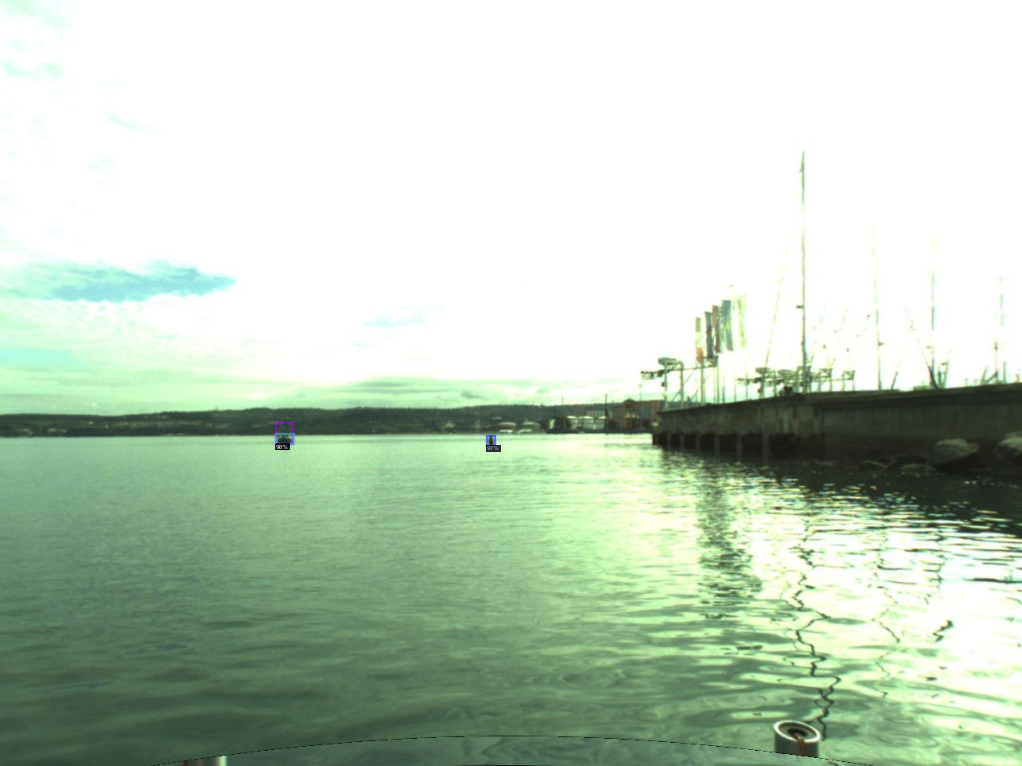

{'file_name': 'Obstacle-Detection-442/data/video_data/kope81-00-00019370-00019710/framesRectified/00019429L.jpg', 'image_id': '00019429L.jpg', 'height': 958, 'width': 1278, 'annotations': [{'bbox': [277.09942878929917, 486.8157187869087, 69.17474837479494, 105.79315424412636], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0, 'iscrowd': 0}]}


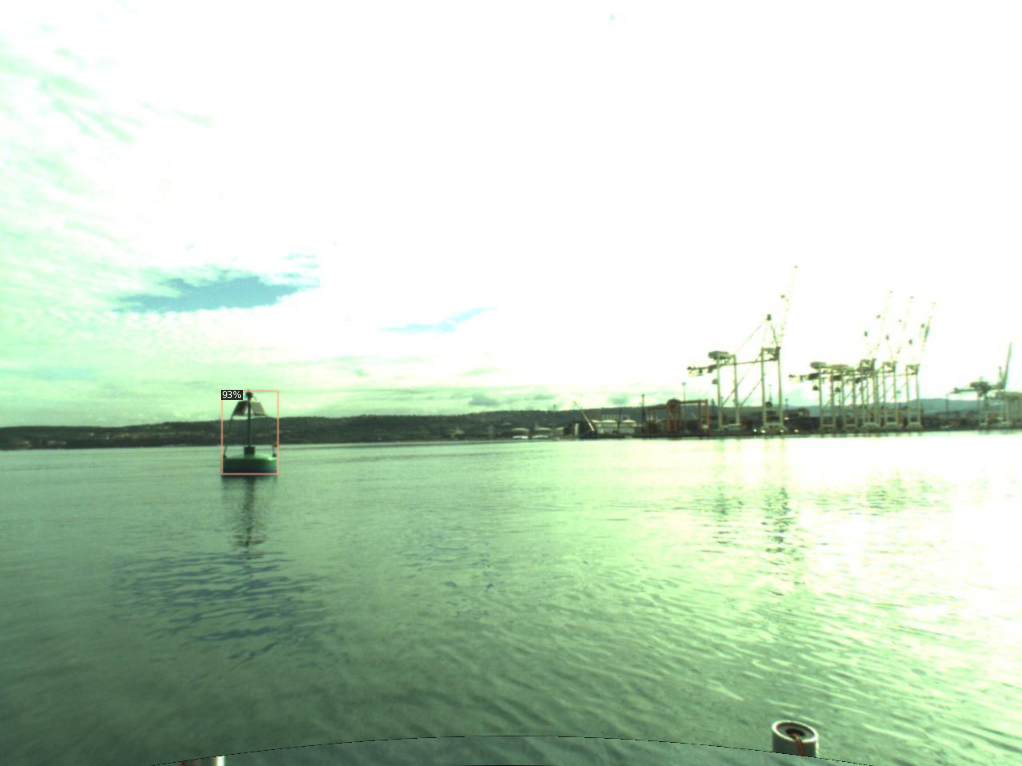

{'file_name': 'Obstacle-Detection-442/data/video_data/kope81-00-00006800-00007095/framesRectified/00007056L.jpg', 'image_id': '00007056L.jpg', 'height': 958, 'width': 1278, 'annotations': [{'bbox': [447.3861467195018, 590.6911939925324, 61.5917480151096, 91.40121378752622], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0, 'iscrowd': 0}]}


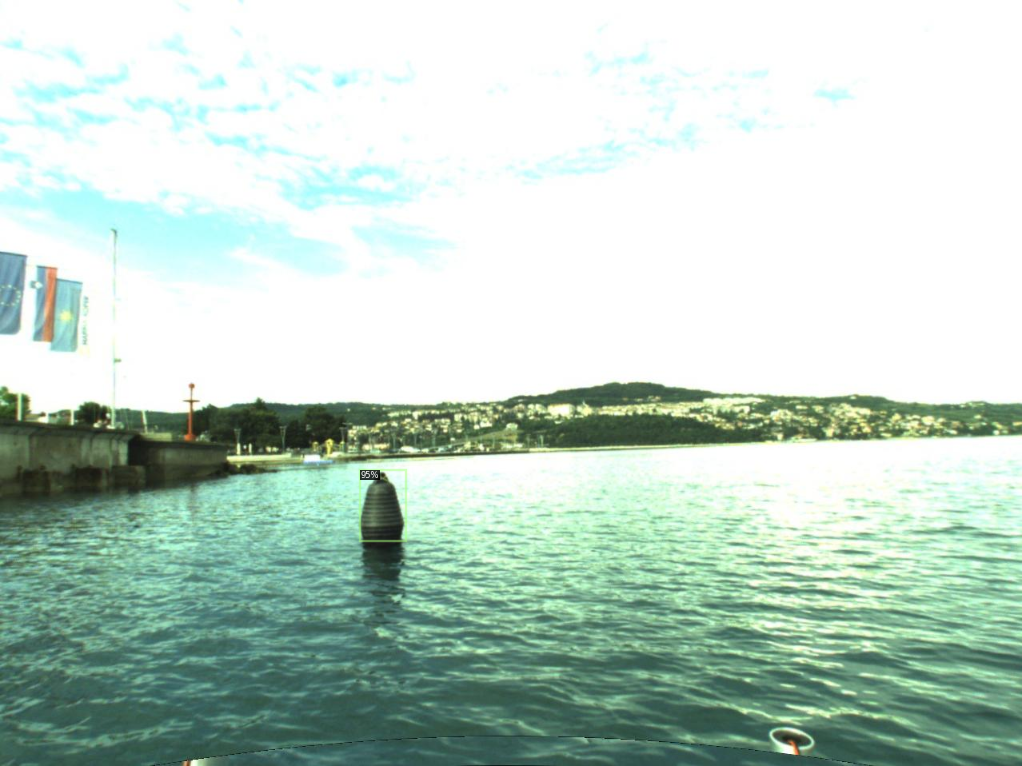

In [0]:
# This code comes from the Detectron2 Getting Started Colab notebook
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_data("val")
for d in random.sample(dataset_dicts, 3):  
    print(d)  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=modd2_metadata, 
                   scale=0.8 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    # v = visualizer.draw_dataset_dict(d)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
# debugging block
print(len(dataset_dicts))
print(DatasetCatalog.list())
print(MetadataCatalog.get("modd2_val"))
print(MetadataCatalog.get("modd2_train"))

# The following cells are custom evaluators

Before running these cells, go into Obstacle-Detection-442/ and pull the file
cocoevalMODD.py out in the content/ directory (the default working directory of Colab)

In [0]:
# This code comes from the Detectron2 example for how to create a custom
# evaluator
from detectron2.evaluation import COCOEvaluator, DatasetEvaluator
class Counter(DatasetEvaluator):
  def reset(self):
    self.count = 0
  def process(self, inputs, outputs):
    for output in outputs:
      self.count += len(output["instances"])
  def evaluate(self):
    # save self.count somewhere, or print it, or return it.
    return {"count": self.count}

In [0]:
# This block reloads the cocoevalMODD module
# Run whenever changes are made to cocoevalMODD.py during session

# cocoevalMODD.py is the source code of cocoeval.py from pycocotools that 
# we adapted to output multiple different statistics at different thresholds
import importlib
import cocoevalMODD
importlib.reload(cocoevalMODD)

In [0]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
# This is mostly Detectron2 source code that was adapted to be used as our 
# custom evaluator, leaning on the cocoevalMODD.py file we made to output
# multiple statistics
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from fvcore.common.file_io import PathManager
from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
from cocoevalMODD import COCOeval
from cocoevalMODD import ParamsMODD
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.logger import create_small_table

from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation import COCOEvaluator, DatasetEvaluator

class COCOEvaluatorForMODD(DatasetEvaluator):
    """
    Evaluate object proposal, instance detection/segmentation, keypoint detection
    outputs using COCO's metrics and APIs.
    """

    def __init__(self, dataset_name, cfg, distributed, output_dir=None):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:
                    "json_file": the path to the COCO format annotation
                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            cfg (CfgNode): config instance
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:
                1. "instance_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
        """
        self._tasks = self._tasks_from_config(cfg)
        self._distributed = distributed
        self._output_dir = output_dir

        self._cpu_device = torch.device("cpu")
        self._logger = logging.getLogger(__name__)

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.warning(
                f"json_file was not found in MetaDataCatalog for '{dataset_name}'."
                " Trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        self._kpt_oks_sigmas = cfg.TEST.KEYPOINT_OKS_SIGMAS
        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset

    def reset(self):
        self._predictions = []

    def _tasks_from_config(self, cfg):
        """
        Returns:
            tuple[str]: tasks that can be evaluated under the given configuration.
        """
        tasks = ("bbox",)
        if cfg.MODEL.MASK_ON:
            tasks = tasks + ("segm",)
        if cfg.MODEL.KEYPOINT_ON:
            tasks = tasks + ("keypoints",)
        return tasks

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            # TODO this is ugly
            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            self._predictions.append(prediction)

    def evaluate(self):
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[COCOEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(set(self._tasks), predictions)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _eval_predictions(self, tasks, predictions):
        """
        Evaluate predictions on the given tasks.
        Fill self._results with the metrics of the tasks.
        """
        ##debugging
        print("THESE ARE MY TASKS:", tasks)
        ##end debug

        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            reverse_id_mapping = {
                v: k for k, v in self._metadata.thing_dataset_id_to_contiguous_id.items()
            }
            for result in coco_results:
                category_id = result["category_id"]
                assert (
                    category_id in reverse_id_mapping
                ), "A prediction has category_id={}, which is not available in the dataset.".format(
                    category_id
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating predictions ...")
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api, coco_results, task, kpt_oks_sigmas=self._kpt_oks_sigmas
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, thresholds=None, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.
        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.
        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP10", "AP15", "AP20", "AP25", "AP30", "AP35", "AP40", "AP45", 
                     "AP50", "AP55", "AP60", "AP65", "AP70", "AP75", "AP80", "AP85", 
                     "AP90", "AP95", "APs", "APm", "APl", "ARd1", "ARd10", "ARd100", 
                     "AR10", "AR15", "AR20", "AR25", "AR30", "AR35", "AR40", "AR45", 
                     "AR50", "AR55", "AR60", "AR65", "AR70", "AR75", "AR80", "AR85", 
                     "AR90", "AR95", "ARs", "ARm", "ARl"],
            # "bbox": ["AP", "AP15", "AP20", "AP25", "AP30", "AP35", "AP40", "AP45", 
            #          "AP50", "AP55", "AP60", "AP15s", "APs", "APm", "APl"],
            # "bbox": ["AP", "AP50", "AP55", "AP60", "AP65", "AP70", "AP75", "AP80", 
            #   "AP85", "AP90", "AP95", "AP50s", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Note that some metrics cannot be computed.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.
    Args:
        instances (Instances):
        img_id (int): the image id
    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        thresholds = torch.arange(0.50, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(coco_gt, coco_results, iou_type, kpt_oks_sigmas=None):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, iou_type)
    # Use the COCO default keypoint OKS sigmas unless overrides are specified
    if kpt_oks_sigmas:
        coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)

    if iou_type == "keypoints":
        num_keypoints = len(coco_results[0]["keypoints"]) // 3
        assert len(coco_eval.params.kpt_oks_sigmas) == num_keypoints, (
            "[COCOEvaluator] The length of cfg.TEST.KEYPOINT_OKS_SIGMAS (default: 17) "
            "must be equal to the number of keypoints. However the prediction has {} "
            "keypoints! For more information please refer to "
            "http://cocodataset.org/#keypoints-eval.".format(num_keypoints)
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval

# Evaluate model performance using AP metric implemented in COCO API.

In [0]:
# This block has code that was modified to be used for our purpose of evaluating
# on our validation set
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluators
from detectron2.data import build_detection_test_loader

USE_CUSTOM_EVAL = True
if USE_CUSTOM_EVAL:
    evaluators = DatasetEvaluators([COCOEvaluatorForMODD("modd2_val", cfg, False, output_dir="./output/"), Counter()])
else:
    evaluators = DatasetEvaluators([COCOEvaluator("modd2_val", cfg, False, output_dir="./output/"), Counter()])
 
val_loader = build_detection_test_loader(cfg, "modd2_val")
eval_results = inference_on_dataset(trainer.model, val_loader, evaluators)
print(eval_results)
# another equivalent way is to use trainer.test

json_file was not found in MetaDataCatalog for 'modd2_val'. Trying to convert it to COCO format ...


[04/25 01:17:21 d2.data.datasets.coco]: Converting dataset annotations in 'modd2_val' to COCO format ...)
[04/25 01:17:22 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/25 01:17:22 d2.data.datasets.coco]: Conversion finished, num images: 1605, num annotations: 1330
[04/25 01:17:22 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/modd2_val_coco_format.json
[04/25 01:17:22 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  obstacle  | 1330         |
|            |              |
[04/25 01:17:22 d2.data.common]: Serializing 1605 elements to byte tensors and concatenating them all ...
[04/25 01:17:22 d2.data.common]: Serialized dataset takes 0.45 MiB
[04/25 01:17:22 d2.evaluation.evaluator]: Start inference on 1605 images
[04/25 01:17:23 d2.evaluation.evaluator]: Inference done 11/1605. 0.0837 s / img. ETA=0:02:15
[04/25 01:17:28 d2.evaluation.evaluator]: Inference done 

In [0]:
def calc_f1(eval_results, iouThr=10):
    """
    This function takes in evaluation results and prints
    out the AP, recall, and F-measure for the requested 
    IoU threshold
    """
    ap = eval_results['bbox']['AP'+str(iouThr)]
    recall = eval_results['bbox']['AR'+str(iouThr)]
    Fmeas = (2*ap*recall) / (ap+recall)
    print("AP:", ap)
    print("recall:", recall)
    print("F-measure:", Fmeas)

calc_f1(eval_results)

AP: 71.09142841706169
recall: 93.08270676691728
F-measure: 80.6141914811488


# Evaluate the model on the test set

In [0]:
# Run this to set the val test set, save the model weights, and set a threshold
# for ROI on the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("modd2_test", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluators
from detectron2.data import build_detection_test_loader

USE_CUSTOM_EVAL = True
if USE_CUSTOM_EVAL:
    evaluators = DatasetEvaluators([COCOEvaluatorForMODD("modd2_test", cfg, False, output_dir="./output/"), Counter()])
else:
    evaluators = DatasetEvaluators([COCOEvaluator("modd2_test", cfg, False, output_dir="./output/"), Counter()])
 
test_loader = build_detection_test_loader(cfg, "modd2_test")
eval_results = inference_on_dataset(trainer.model, test_loader, evaluators)
print(eval_results)
# another equivalent way is to use trainer.test

In [0]:
def calc_f1(eval_results, iouThr=10):
    ap = eval_results['bbox']['AP'+str(iouThr)]
    recall = eval_results['bbox']['AR'+str(iouThr)]
    Fmeas = (2*ap*recall) / (ap+recall)
    print("AP:", ap)
    print("recall:", recall)
    print("F-measure:", Fmeas)

calc_f1(eval_results)